# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

### Изучение общей информации о данных

Загрузим каждый регион в отдельный датафрейм, изучив общую информацию о данных

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_0.info()
geo_data_0.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [3]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_1.info()
geo_data_1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [4]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
geo_data_2.info()
geo_data_2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


### Визуализация данных

In [5]:
#функция для проверки пропущенных значений, наличия дубликатов и проверки распределения признаков
def exploratory(data):
    print(f'Shape:    {data.shape}')
    print("Na's:         ", data.isna().sum().sum())
    print("duplicates:   ", data.duplicated().sum())
    print("\nРаспределение признаков:")
    sns.histplot(data[["f0","f1","f2"]], binwidth = 3)
    plt.show()

Shape:    (100000, 5)
Na's:          0
duplicates:    0

Распределение признаков:


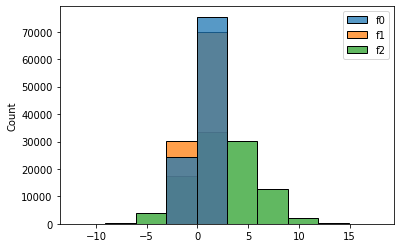

In [6]:
exploratory(geo_data_0)

Shape:    (100000, 5)
Na's:          0
duplicates:    0

Распределение признаков:


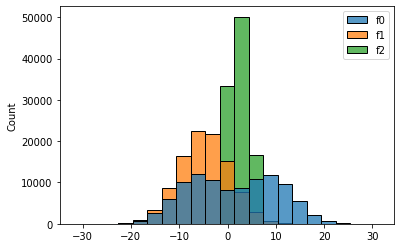

In [7]:
exploratory(geo_data_1)

Shape:    (100000, 5)
Na's:          0
duplicates:    0

Распределение признаков:


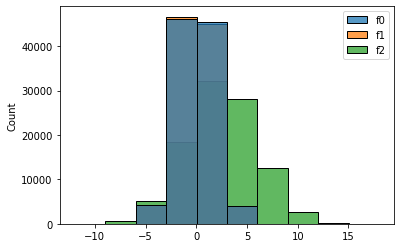

In [8]:
exploratory(geo_data_2)

In [9]:
def oil_hist(seria, bins, xlim_max, ylim_max):
    plt.figure(figsize=[12,9])

    sns.histplot(seria, bins=bins)

    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])

    plt.xlabel("Объем нефти на скважину, тыс. барелей")
    plt.ylabel("Количество скважин")

    plt.title("Гистограмма распределения по объему скважин")
    plt.show()

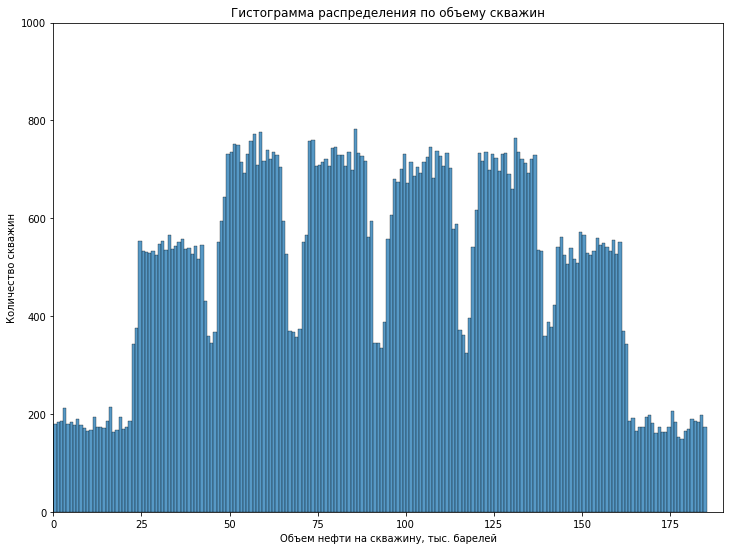

In [10]:
oil_hist(geo_data_0['product'], 200, 190, 1000)

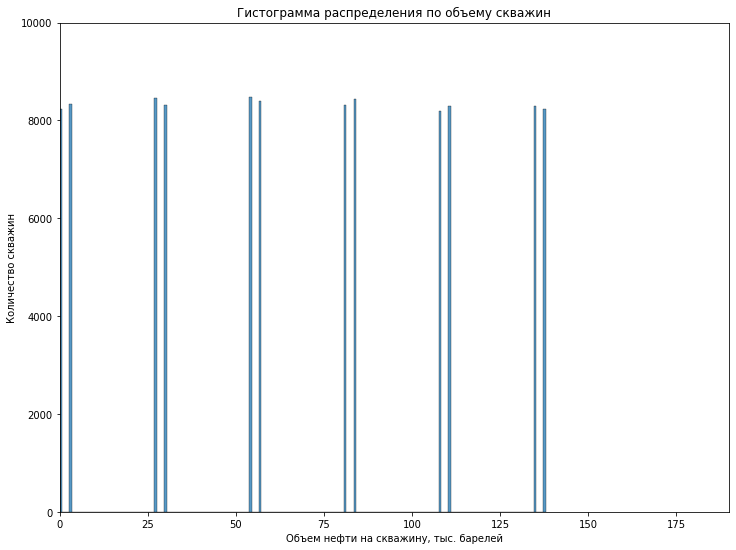

In [11]:
oil_hist(geo_data_1['product'], 200, 190, 10000)

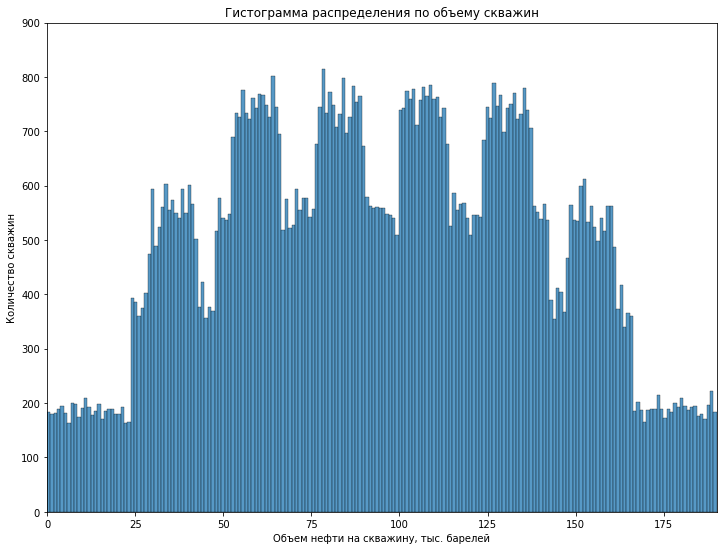

In [12]:
oil_hist(geo_data_2['product'], 200, 190, 900)

### Заполнение выбивающихся значений

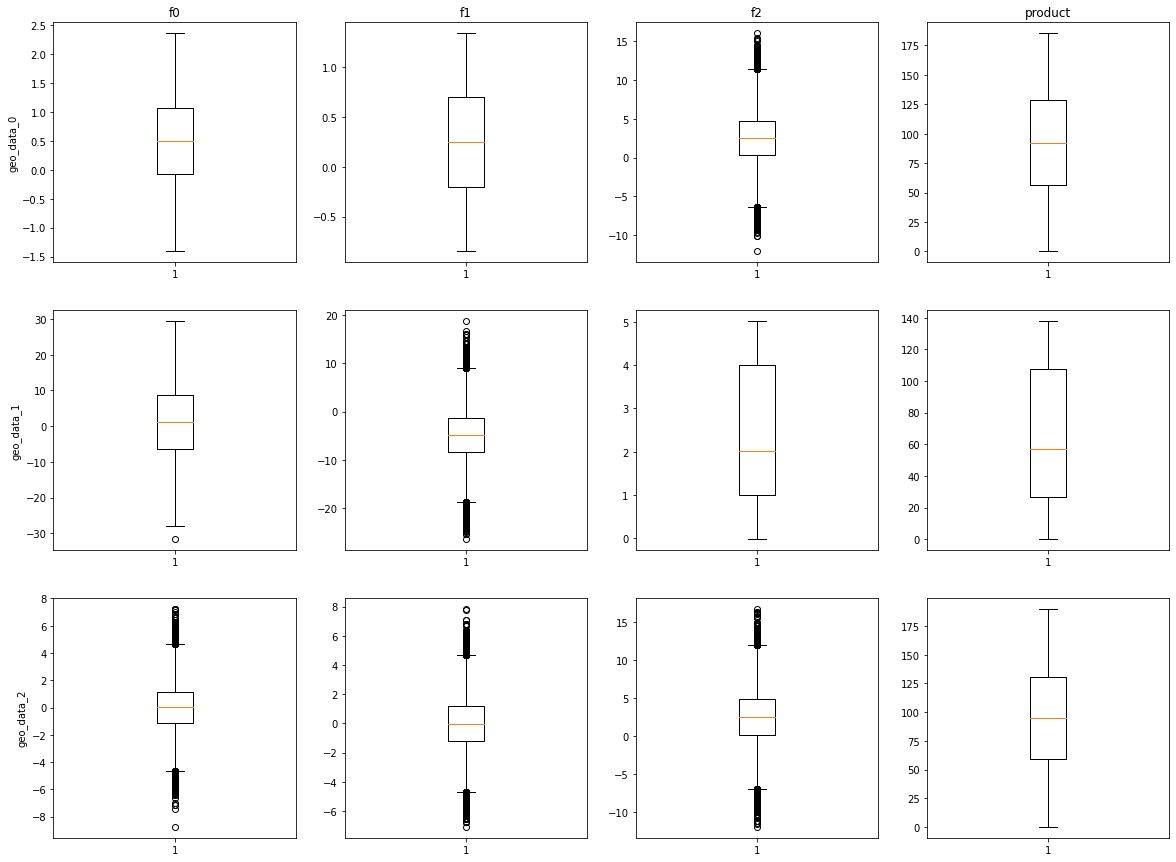

In [13]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

all_frames = ["geo_data_0","geo_data_1","geo_data_2"]
num_columns = geo_data_0.columns[1:]
num_columns_with_columns = zip(geo_data_0.columns[1:],range(4))
all_frames_with_rows = zip([geo_data_0,geo_data_1,geo_data_2],range(3))
# Построим графики
for column in list(itertools.product(all_frames_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])
# Добавим название фрейма изображаемого на графике
for row in range(3):
    ax[row][0].set_ylabel(all_frames[row])
# Добавим название столбца изображаемого на графике
for column in range(4):
    ax[0][column].set_title(num_columns[column])

In [14]:
def remove_ouliers(frame,column):
    q25=np.array(frame[column].quantile(0.25))
    
    q75=np.array(frame[column].quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    del_index = []
    for index_value, value in zip(frame[column].index,frame[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Количество строк, выбранных для удаления: ',len(del_index))
    return del_index

In [15]:
noise_data = [(geo_data_0,"f2"),
 (geo_data_1,"f1"),
 (geo_data_2,"f0"),
 (geo_data_2,"f1"),
 (geo_data_2,"f2")]

for frame,column in noise_data:
    indexes = remove_ouliers(frame,column)
    frame.drop(indexes,axis = 0,inplace = True)

Количество строк, выбранных для удаления:  506
Количество строк, выбранных для удаления:  636
Количество строк, выбранных для удаления:  733
Количество строк, выбранных для удаления:  682
Количество строк, выбранных для удаления:  582


В данных отсутсвуют пропуски. Удалим из каждого датафрейма столбец id. Он не несет значимости для для модели.

In [16]:
geo_data_0 = geo_data_0.reset_index(drop = True)
geo_data_1 = geo_data_1.reset_index(drop = True)
geo_data_2 = geo_data_2.reset_index(drop = True)

### Проверка корреляции между признаками

<AxesSubplot:>

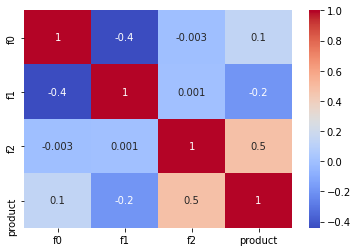

In [17]:
sns.heatmap(geo_data_0.corr(), annot = True, fmt='.1g', cmap= 'coolwarm')

<AxesSubplot:>

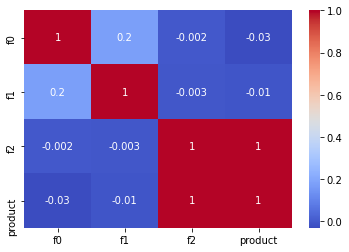

In [18]:
sns.heatmap(geo_data_1.corr(), annot = True, fmt='.1g', cmap= 'coolwarm')

<AxesSubplot:>

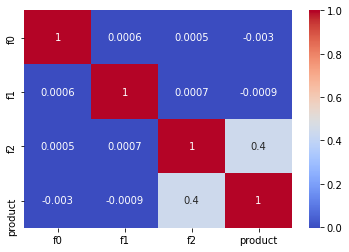

In [19]:
sns.heatmap(geo_data_2.corr(), annot = True, fmt='.1g', cmap= 'coolwarm')

In [20]:
geo_data_0 = geo_data_0.drop(['id'], axis=1)
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1)

**Вывод по шагу 1:**

Данные готовы к обучению. 

Во втором месторождении около 8,2% месторождений не имело значения в столбце product. При сравнении с такими же значениями из первого и третьего региона можно предположить, что были утеряны данные или не было исследовано количество барелей нефти.

По гистограммам можно понять, что у первого и третьего региона наспределение скважин близкое к нормальному. 
Во втором регионе данные имеют странное распределение: от 0 до 5 баррелей с шагом по 15-20 равномерно распределены 100000 значений. Данные не подчиняются закону больших чисел и, возможно, были введены искуственно.

Признаки для модели: 
- *f0;*
- *f1;*
- *f2.*

Целевой признак: 
- *product.*


## Обучение и проверка модели

Проверим качество модели линейной регрессии с текущим значением признаков и с масштабируемыми. Проверим эту гипотезу на geo_data_0. Выполняем разбивку неподготовленного датафрейма.

In [21]:
def test_split(df, target):
    features = df.drop([target] , axis=1)
    target = df[target]

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=5062020)
    
    return features_train, features_valid, target_train, target_valid

In [22]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = test_split(geo_data_0, 'product')

features_train_0.head()

,f0,f1,f2
61380,0.082153,1.020137,3.720367
81456,0.347326,0.889149,-0.659423
93894,0.266099,-0.201654,4.220563
87380,0.847291,-0.417228,1.001541
73641,0.166807,0.949760,-3.939722


In [23]:
def test_split_scaled(df, numeric, target):
    geo_data_s = df.copy()

    features_s = geo_data_s.drop([target] , axis=1)
    target_s = geo_data_s[target]

    features_train_s, features_valid_s, target_train_s, target_valid_s = train_test_split(
        features_s, target_s, test_size=0.25, random_state=5062020)

    scaler = StandardScaler()
    scaler.fit(features_train_s[numeric])
    features_train_s[numeric] = scaler.transform(features_train_s[numeric])
    features_valid_s[numeric] = scaler.transform(features_valid_s[numeric])

    return features_train_s, features_valid_s, target_train_s, target_valid_s

1. features - данные без масштаба
2. features_s - данные с масштабом

Видно, что данные изменились теперь проведем обучение модели без измененных данных. 

In [24]:
model = LinearRegression()

model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE -', mean_squared_error(target_valid_0, predicted_target_0)**0.5)

RMSE - 37.522739361207734


Проверим каково RMSE на маштабированных данных.

In [25]:
features_train_0s, features_valid_0s, target_train_0s, target_valid_0s = test_split_scaled(
                                                                        geo_data_0, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_0s, target_train_0s)
predicted_target_0s = model.predict(features_valid_0s)
print('RMSE -', mean_squared_error(target_valid_0s, predicted_target_0s)**0.5)

RMSE - 37.522739361207734


In [26]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = test_split(geo_data_1, 'product')
model.fit(features_train_1, target_train_1)
predicted_target_1 = model.predict(features_valid_1)
print('RMSE -', mean_squared_error(target_valid_1, predicted_target_1)**0.5)

features_train_1s, features_valid_1s, target_train_1s, target_valid_1s = test_split_scaled(
                                                                        geo_data_1, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_1s, target_train_1s)
predicted_target_1s = model.predict(features_valid_1s)
print('RMSE -', mean_squared_error(target_valid_1s, predicted_target_1s)**0.5)

RMSE - 0.8846644310075582
RMSE - 0.8846644310075581


In [27]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = test_split(geo_data_2, 'product')
model.fit(features_train_2, target_train_2)
predicted_target_2 = model.predict(features_valid_2)
print('RMSE -', mean_squared_error(target_valid_2, predicted_target_2)**0.5)

features_train_2s, features_valid_2s, target_train_2s, target_valid_2s = test_split_scaled(
                                                                        geo_data_2, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_2s, target_train_2s)
predicted_target_2s = model.predict(features_valid_2s)
print('RMSE -', mean_squared_error(target_valid_2s, predicted_target_2s)**0.5)

RMSE - 39.973467830251884
RMSE - 39.973467830251884


Масштабирование данных не требуется. Проверим показатель RMSE при других гиперпараметрах модели.

In [28]:
model = LinearRegression(normalize=True)
model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE -', mean_squared_error(target_valid_0, predicted_target_0)**0.5)

RMSE - 37.522739361207734


In [29]:
model = LinearRegression(fit_intercept=False)
model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE -', mean_squared_error(target_valid_0, predicted_target_0)**0.5)

RMSE - 60.34243802997542


Изменение стандартных значений гиперпараметров не улучшило модель. Произведем вывод предсказанного запаса с реальным и выведем RMSE.

In [30]:
model = LinearRegression()

def oil_predict(df, target_name):
    features = df.drop([target_name] , axis=1)
    target = df[target_name]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=5062020)
    
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    data = {'real_product' : target_valid,
            'predicted_product' : predicted_target         
    }
    data_frame = pd.DataFrame(data, columns = ['real_product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    mean = data_frame['predicted_product'].mean()
    oil_sum = data_frame['predicted_product'].sum()
    return data_frame, rmse, mean, oil_sum

In [31]:
geo_data_0_predicted, geo_data_0_rmse, geo_data_0_predicted_mean, geo_data_0_predicted_sum = oil_predict(geo_data_0, 'product')
print(geo_data_0_predicted.head())
print('RMSE -', geo_data_0_rmse)
print('Средний запас запасанного сырья -', geo_data_0_predicted_mean)

       real_product  predicted_product
34031    132.013360         101.721235
71295    127.747440         101.475536
51188    146.357394         147.751224
89370     16.116933          76.725541
23403    132.063108          60.760323
RMSE - 37.522739361207734
Средний запас запасанного сырья - 92.6114484521939


In [32]:
geo_data_1_predicted, geo_data_1_rmse, geo_data_1_predicted_mean, geo_data_1_predicted_sum = oil_predict(geo_data_1, 'product')
print(geo_data_1_predicted.head())
print('RMSE -', geo_data_1_rmse)
print('Средний запас запасанного сырья -', geo_data_1_predicted_mean)

       real_product  predicted_product
59670     57.085625          55.098356
508      107.813044         108.595791
77323     30.132364          28.612257
92030     30.132364          30.067975
33500     80.859783          81.834507
RMSE - 0.8846644310075582
Средний запас запасанного сырья - 68.98509316704175


In [33]:
geo_data_2_predicted, geo_data_2_rmse, geo_data_2_predicted_mean, geo_data_2_predicted_sum = oil_predict(geo_data_2, 'product')
print(geo_data_2_predicted.head())
print('RMSE -', geo_data_2_rmse)
print('Средний запас запасанного сырья -', geo_data_2_predicted_mean)

       real_product  predicted_product
84883    152.588973         128.379182
43135     19.707841         102.549292
36430    120.838058          95.843200
93441    112.791842         116.560184
87932    135.706205          92.465885
RMSE - 39.973467830251884
Средний запас запасанного сырья - 94.77150572060633


Оценим общий запас на регион по предсказанным данным.

In [34]:
print('Суммарный предсказанный запас в позиции 0 -', geo_data_0_predicted_sum)
print('Суммарный реальный запас в позиции 0 -', geo_data_0_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в позиции 1 -', geo_data_1_predicted_sum)
print('Суммарный реальный запас в позиции 1 -', geo_data_1_predicted['real_product'].sum())
print()
print('Суммарный предсказанный запас в позиции 2 -', geo_data_2_predicted_sum)
print('Суммарный реальный запас в позиции 2 -', geo_data_2_predicted['real_product'].sum())

Суммарный предсказанный запас в позиции 0 - 2303617.168799871
Суммарный реальный запас в позиции 0 - 2290785.3117362503

Суммарный предсказанный запас в позиции 1 - 1713658.699362484
Суммарный реальный запас в позиции 1 - 1713485.0120418195

Суммарный предсказанный запас в позиции 2 - 2321996.661660576
Суммарный реальный запас в позиции 2 - 2322326.524473088


**Вывод по шагу 2:** 

Данные предсказаний о количестве нефти по сумме примерно совпадают по сумме с предсказанными значениями.
Лучше всего модель предсказала запасы во втором регионе (RMSE - 0.88), далее в первом и третьем соотвественно.


Возможно утеряные данные из второго региона сказались на модели и она достаточно сильно переобучилась.


Но из-за утери данных и малого запаса в среднем на месторождение, не имеет смысла рассматривать месторождение под номером 2 как прибыльное.


Изучим все регионы на риски и прибыль, но в конечном итоге будем выбирать между 1 и 3 регионом.

## Подготовка к расчёту прибыли

Создадим переменные об экономической информации.

In [35]:
budget = 1e+07 #Мы расчитываем прибыль в тысячах рублей за тысячу барелей, поэтому 1 милиард сохранен таким образом
chosen_points = 500
best_points = 200
price_per_barrel = 450

Расчитаем безубыточную разработку сырья на 200 месторождениях. И найдем среднее количество продукта в месторождениях необходимое для этого.

In [36]:
average_profit_per_point = budget / best_points
print('Средняя прибыль на лучшую точку -', average_profit_per_point, 'тыс.руб.')

average_barrels_per_point = average_profit_per_point  / price_per_barrel
print('Средний объем нефти на точку -',average_barrels_per_point, 'тыс. барелей')

average_barrels = budget / price_per_barrel
print('Средний объем нефти на регион -',average_barrels, 'тыс. барелей')

Средняя прибыль на лучшую точку - 50000.0 тыс.руб.
Средний объем нефти на точку - 111.11111111111111 тыс. барелей
Средний объем нефти на регион - 22222.222222222223 тыс. барелей


In [37]:
print('Средний запас фактичекой нефти на скважину в регионе 1 - ', geo_data_0['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 2 - ', geo_data_1['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 3 - ', geo_data_2['product'].mean())

Средний запас фактичекой нефти на скважину в регионе 1 -  92.50067661514835
Средний запас фактичекой нефти на скважину в регионе 2 -  68.80991858101544
Средний запас фактичекой нефти на скважину в регионе 3 -  94.78507187440762


Создадим функцию для расчета приыли на 500 разведанных точек.

In [38]:
def oil_profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return price_per_barrel * selected.sum() - budget

Выведем распределение предсказанных значений.

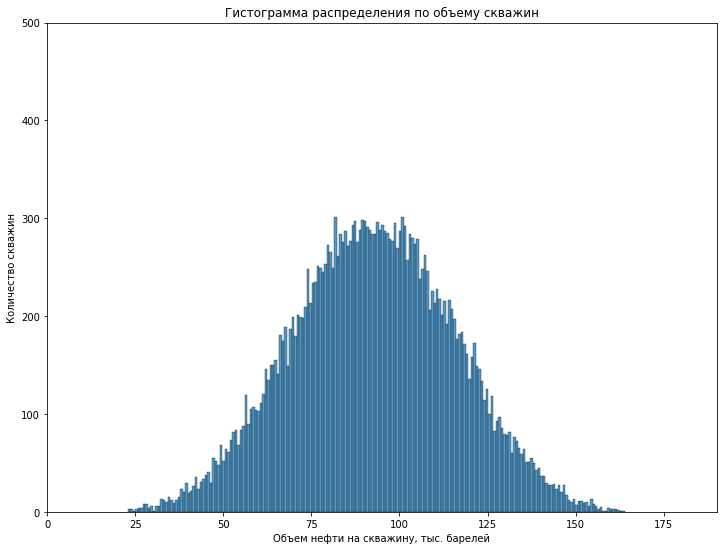

In [39]:
oil_hist(geo_data_0_predicted['predicted_product'], 200, 190, 500)

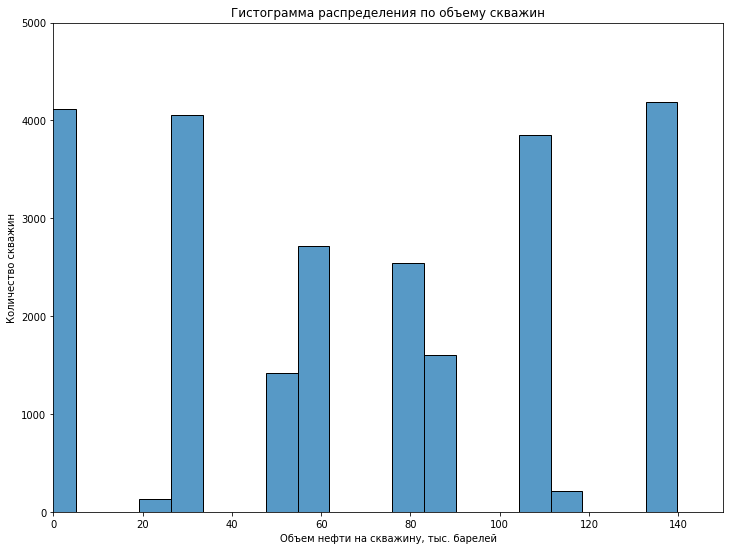

In [40]:
oil_hist(geo_data_1_predicted['predicted_product'], 20, 150, 5000)

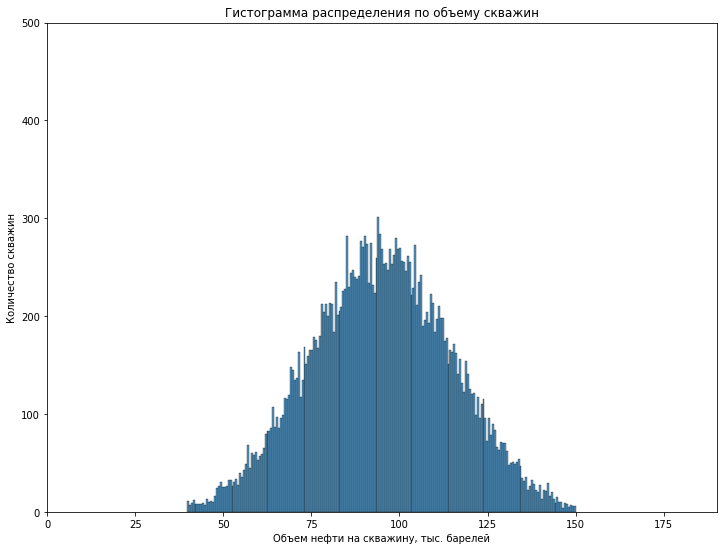

In [41]:
oil_hist(geo_data_2_predicted['predicted_product'], 200, 190, 500)

**Вывод по шагу 3:**

Была подготовлена средняя оценка прибили за скважину и средний объем на скважину. И создана функция по расчету прибыли.

Анализ средних объемов на скважину для каждого региона следующий.

Изучены средние фактические запасы. Для первого и третьего - высокая вероятность окупить затраты. Разброс значений вокруг среднего 92.5 и 95 говорит нам о том, что существует достаточно много скважин, где запасы больше необходимого среднего.

В данных из второго датафрейма, возможно, есть определенный смысл - значений больше 111 достаточно много и при определенной доли везения можно выбрать только лучшие в этой выборке, хотя и среднее значение 68.8.

## Расчёт прибыли и рисков 

In [42]:
state = np.random.RandomState(5062020)
def bootstrap_1000(target, probs):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=chosen_points)
        probs_sample = probs[target_sample.index]
        profit = oil_profit_calculation(target, probs_sample, best_points)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

In [43]:
average_0, lower_0, upper_0, risk_0 = bootstrap_1000(geo_data_0_predicted['real_product'], 
                                                     geo_data_0_predicted['predicted_product'])
print('Данные по первому региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_0))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_0, upper_0))
print('Процент риска {:.2%}'.format(risk_0))

Данные по первому региону.
Средняя прибыль по региону = 425551.33 тыс.руб.
95% доверительный интервал от -90799.78 до 935524.57 тыс.руб.
Процент риска 5.80%


In [44]:
average_1, lower_1, upper_1, risk_1 = bootstrap_1000(geo_data_1_predicted['real_product'], 
                                                     geo_data_1_predicted['predicted_product'])
print('Данные по первому региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Данные по первому региону.
Средняя прибыль по региону = 479779.94 тыс.руб.
95% доверительный интервал от 78025.93 до 885850.93 тыс.руб.
Процент риска 1.20%


In [45]:
average_2, lower_2, upper_2, risk_2 = bootstrap_1000(geo_data_2_predicted['real_product'], 
                                                     geo_data_2_predicted['predicted_product'])
print('Данные по первому региону.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_2))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))

Данные по первому региону.
Средняя прибыль по региону = 284462.12 тыс.руб.
95% доверительный интервал от -212786.88 до 778797.34 тыс.руб.
Процент риска 14.40%


**Вывод по шагу 4:**

Данные были обработаны и рассчитаны прибыль, интервал и риски.

Мы отсеиваем первый и третий регион, так как риски остаточно велики.
Остается один единственный - второй, чей риск ниже требуемого. Кроме того доверительный интервал показывает, что даже при не очень удачном выборе разработка скважин окупится.

# Итоговый вывод

При выполнении следующего проекта было выполнено:

1. Изучины данные. Проведена подготовка данных к моделированию (пропусков нет, дубликатов нет, выбивающиеся (аномальные) значение устранены, масштабирование данных не потребовалось)
2. Обучена модель для каждого региона geo_data_0, geo_data_1 и geo_data_2. (проведена работа с гиперпараметрами модели)
3. Составлена функция расчета прибыли в регионе.
4. Посчитана прибыль и риски за каждый регион и обоснован выбор региона.

***Второй*** регион получился одним из лучших по показателям предсказывания, хотя данные не выглядят нормально распределенными.